## Notebook Organization Notes and Errata
This notebook is meant to be both an educational tool, and lightweight-yet-fully-functional utility for training language models. These are two generally opposing goals, and this tension has motivated some of the choices and sacrifices I've made.

* This notebook is organized in a bottom-up approach. Lower-level components, such as specific embedding, attention, and feed-forward classes are defined first, and used later, so that one could feasibly shift+enter their way through the entire notebook without issue. 

* I have presented, in many cases, several different classes for each component. This is an intentional choice. One can (hopefully, if I've done my job right) see the similarities between the methodologies in spite of their minor differences. My focus on the Llama(-esque) architecture as the "modern" approach is primarily dictated by the ubiquity of this architecture and their specific metholodological choices across different language models, and the clear success it has shown at *modelling language*. I've put some effort into making the components more interchangeable than their original forms, and I don't think I've introduced any significant errors (famous last words).

* For clarity of code in the notebook itself, non-architectural utilities and other methods have been moved to separate files, so that the focus of the code presented here is *how* the information is modified as it flows through the model. I've also neglected to include certain optimizations and additions (e.g. KV caches, dynamic RoPE scaling, etc) to avoid adding undue complexity. If you want to use transformer-based models for any task that requires performance, you have *plenty* of other frameworks to use.

* The training loop method uses several values set in globals.py (accessed via a widget interface), which it copies the values of so that they remain consistent during a single training run, even if the widget is changed. Widget controls aren't incredibly fine-grained, but are serviceable. This system will also "allow" you to use settings that will fail/use too much VRAM. Settings-tuning is on my radar, but is out of scope for now.

* It's *very* important to note that a vast majority of the code in this notebook (and in the utility files) is adapted from other sources. I've done my best to note those sources, and to explain any modifications I've made. This is the nature of Software Development, and it's my hope that the work I've done here will empower people to dive deeper into the sources themselves, armed with a better understanding of how it's working at the lowest level.

<sup>Thorold Tronrud, ML/AI Software Engineer, StarFish Medical</sup>

In [ ]:
# install dependencies - skip if you're coming into this already set up
!pip install --upgrade torch numpy datasets tiktoken wandb tqdm torchinfo matplotlib

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import math
import torch.nn as nn
from torch.nn import functional as F
from enum import Enum
from dataclasses import dataclass
from IPython import display
from torchinfo import summary
import tiktoken
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import trange
import torch.jit as jit
from typing import List
import globals as g
from modelling_utils import apply_rotary_pos_emb, repeat_kv, Transformer, clean_class_name, pretty_generate
from training_utils import plot_grad_flow, get_lr, get_batch, generate_training_data
import wandb
g.get_device()

# if running on machine with multiple GPUs, you can set a specific device like this:
# g.set_device("cuda:0")

Using cuda


## Embeddings
Embeddings convert a stream of discrete tokens into a trajectory through a semantic space. In many cases, these word-token-embeddings are mixed with positional embeddings -- either absolute and learned (e.g. GPT2) or sinusoidal across the sequence length (e.g. LLama, etc). Positional embeddings provide the model information about relative placement of different tokens, and distance between them, which is sometimes useful in language. 

"NoPE", or "No Positional Embeddings" has shown success, however, so YMMV.

In [3]:
class AbsolutePositionalEmbeddings(nn.Module):
    """
    GPT-2 style word-token embeddings + absolute positional embeddings
        Combines word-token-embeddings and word-position-embeddings to transmit
        both pieces of information throughout the rest of the model
    """
    def __str__(self):
        return "AbsolutePositionalEmbeddings"
        
    def __init__(self, config):
        super().__init__()
        #validity assertions
        assert config.max_seq_len > 0, f"Max positional embeddings must be > 0: set max_seq_len positive"
        
        self.vocab_size = config.vocab_size
        self.n_embed = config.n_embd
        self.max_positional_embeddings = config.max_seq_len

        self.wte = nn.Embedding(self.vocab_size, self.n_embed)
        self.wpe = nn.Embedding(self.max_positional_embeddings, self.n_embed)
        self.drop = nn.Dropout(config.dropout)

    def forward(self, idx):
        #batch, seq_len
        b, seq_len = idx.size()
        assert seq_len <= self.max_positional_embeddings, f"Input sequence length {seq_len} is greater than max positional embeddings of {self.max_positional_embeddings}"

        tok_emb = self.wte(idx)
        pos_emb = self.wpe(torch.arange(0, seq_len, dtype=torch.long, device=idx.device))
        emb = self.drop(tok_emb + pos_emb)
        return emb

class WordTokenEmbeddings(nn.Module):
    """
    Word-token-embeddings only
        For use in other architectures that handle positional embeddings
        differently (e.g. LLama)
    """
    def __str__(self):
        return "WordTokenEmbeddings"
        
    def __init__(self, config):
        super().__init__()
        self.vocab_size = config.vocab_size
        self.n_embed = config.n_embd

        self.wte = nn.Embedding(self.vocab_size, self.n_embed)
        self.drop = nn.Dropout(config.dropout)

    def forward(self, idx):
        tok_emb = self.wte(idx)
        return self.drop(tok_emb)

class LlamaRotaryEmbedding(nn.Module):
    """
    LLama-style rotary embeddings adapted from Transformers LLama source
    https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L94

        !!Applied in the self-attention module, not as part of embedding block!!
    """
    def __str__(self):
        return "RotaryPositionalEmbedding"
        
    def __init__(self, dim, max_position_embeddings=1024, base=10000, device=None, scaling_factor=1.0):
        super().__init__()
        self.scaling_factor = scaling_factor
        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2, dtype=torch.int64).float().to(device) / self.dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)
        # For BC we register cos and sin cached
        self.max_seq_len_cached = max_position_embeddings

    @torch.no_grad()
    def forward(self, x):
        # x: [bs, num_attention_heads, seq_len, head_size]
        bs,nh,sl,embd = x.size()
        position_ids = torch.arange(0,sl, device=x.device).unsqueeze(0)
        # float32 precision required according to source
        # https://github.com/huggingface/transformers/pull/29285
        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        position_ids_expanded = position_ids[:, None, :].float()
        
        freqs = (inv_freq_expanded @ position_ids_expanded).transpose(1, 2)
        emb = torch.cat((freqs, freqs), dim=-1)
        cos = emb.cos()
        sin = emb.sin()
        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)

## Attention
Attention is the main ingredient that makes Transformers so powerful. An attention block is composed of different attention "heads", which control the flow of information, interact between model layers, and each add their own information to the residual.

Each attention head computes "query", "key", and "value" vectors for each input token. The attention pattern is the dot product of the query and key vectors, giving a value for the effect each token has on every other token. Finally, multiplying this token-token effect matrix by the value matrix gives a result vector for the head.

The results for all heads are stacked side-by-side and passed through a final output layer, which produces the block's predicted "change" to the semantic position of all the tokens.

[This article](https://transformer-circuits.pub/2021/framework/index.html) does an amazing job breaking down the function of attention heads, albeit with a slightly different model for their behaviour.

In [4]:
class MHASelfAttention(nn.Module):
    """
    LLama-style Multi-Head Attention with rotary embeddings
    https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L577

    Modified to include same manual attention fallback
    """
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.o_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.resid_dropout = nn.Dropout(config.dropout)
        self.using_rotary_encoding = False
        if config.rotary_encoding:
            self.rotary_emb = LlamaRotaryEmbedding(config.n_embd//config.n_head, max_position_embeddings = config.max_seq_len)
            self.using_rotary_encoding = True
        else:
            self.rotary_emb = None
        
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.max_seq_len, config.max_seq_len))
                                        .view(1, 1, config.max_seq_len, config.max_seq_len))
    
    def forward(self, x, position_embeddings = None):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        """
        Primary difference in positional embeddings implementation.
        This encodes the positions of each part of the inputs into the attention
        matrix, as opposed to encoding it directly into the embedding trajectory
        """
        if self.using_rotary_encoding:
            if position_embeddings is None:
                cos, sin = self.rotary_emb(v)
            else:
                cos, sin = position_embeddings
            q, k = apply_rotary_pos_emb(q, k, cos, sin)
        
        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v
            
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.o_proj(y))
        return y

class GQASelfAttention(nn.Module):
    """
    LLama-style Grouped Query Attention with rotary embeddings
    https://arxiv.org/pdf/2305.13245
    https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L577

    Causal SA is really just the case where the number of KV heads is equal to the number of Q heads,
    but I've separated it here to have a "simpler" case available. Compilation *should* take care
    of most of the performance differences w/r/t performing matrix multiplications in one go or not
    """
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        assert config.n_head % config.n_kv_head == 0
        
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_dim = self.n_embd//self.n_head
        self.num_key_value_heads = config.n_kv_head
        self.num_key_value_groups = self.n_head // self.num_key_value_heads
        
        # Q, K, and V aren't identical in size anymore, so can't batch all in one MatMul
        self.q_proj = nn.Linear(self.n_embd, self.n_head*self.head_dim, bias = config.bias)
        self.k_proj = nn.Linear(self.n_embd, self.num_key_value_heads*self.head_dim, bias = config.bias)
        self.v_proj = nn.Linear(self.n_embd, self.num_key_value_heads*self.head_dim, bias = config.bias)
        
        # output projection
        self.o_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        
        # regularization
        self.resid_dropout = nn.Dropout(config.dropout)

        
        self.using_rotary_encoding = False
        if config.rotary_encoding:
            self.rotary_emb = LlamaRotaryEmbedding(config.n_embd//config.n_head, max_position_embeddings = config.max_seq_len)
            self.using_rotary_encoding = True
        else:
            self.rotary_emb = None
        
        self.dropout = config.dropout
        
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.max_seq_len, config.max_seq_len))
                                        .view(1, 1, config.max_seq_len, config.max_seq_len))

    def forward(self, x, position_embeddings = None):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)
        
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2) # (B, nh, T, hs)
        k = k.view(B, T, self.num_key_value_heads, self.head_dim).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.num_key_value_heads, self.head_dim).transpose(1, 2) # (B, nh, T, hs)

        
        if self.using_rotary_encoding:
            if position_embeddings is None:
                cos, sin = self.rotary_emb(v)
            else:
                cos, sin = position_embeddings
            q, k = apply_rotary_pos_emb(q, k, cos, sin)

        """
        Primary difference with rotary MHA -- KV groups are repeated to match
        Q dimension before being passed through SDPA
        """
        k = repeat_kv(k, self.num_key_value_groups)
        v = repeat_kv(v, self.num_key_value_groups)
        
        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v
            
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.o_proj(y))
        return y


"""
A "fun" alternative architecture based on RNNs. Also much slower for similar sequence lengths!
https://arxiv.org/pdf/2402.19427
RNNs are the "old" way of doing NLP, and have had some minor resurgence recently.
They are much more memory-efficient in the forward pass - since Attention requires
memory in some linear (with Flash Attention 2, otherwise it's quadratic) relation
with the amount of text passed into it, an RNN requires the same amount of memory
for any input lengths, it just takes longer as it passes each step through. 

First part to define is the RG-LRU cell, which performs a single "time step"
"""
class RGLRUCell(jit.ScriptModule):
    def __init__(self, input_size, hidden_size, epsilon = 1e-10):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.c = -8  # Scalar-valued constant
        self.eps = epsilon

        # Initialize weights
        #We're combining the Wa and Wx matrices to reduce the operations 
        #to a single mat-mul. We can then chunk out the rt and it halves
        self.WaWx = nn.Linear(input_size, 2*hidden_size)
        
        self.Lambda = nn.Parameter(torch.Tensor(hidden_size))  # Λ
        # Initialize parameters
        self.reset_parameters()
        
    def reset_parameters(self):
        self.Lambda.data.uniform_(
            torch.logit(torch.tensor(0.9)),
            torch.logit(torch.tensor(0.999)),
        )    
    @jit.script_method    
    def forward(self, xt, state):
        rt_it = self.WaWx(xt)
        rt, it = rt_it.split(self.hidden_size, dim=2)
        rt = torch.sigmoid(rt)
        it = torch.sigmoid(it)
        a = torch.sigmoid(self.Lambda)
        at = a**rt
        # in my experimentation, an epsilon term was required to prevent
        # infinite gradients - because the derivative of (1 - x)^0.5 @ x = 1
        # is infinite... ¯\_(ツ)_/¯ wasn't mentioned in the paper
        state = at * state + torch.sqrt(1 - at**2 + self.eps) * (it * xt)
        return state

"""
The RG-LRU Recurrent Block, which passes the input signal through the cell to modify
the hidden state, which is gated by a parallel linear layer.

    I opted to ignore the convolutional step. This doesn't perform well enough
    on my normie hardware (vs Google's dedicated TPUs with handcrafted CUDA kernels)
    to really test vs attention. Might explain why Attention's taken over...
"""
class RGLRURecurrentBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.rglru_hidden_size > 0

        self.rglru_init_h = torch.zeros(config.rglru_hidden_size)
        self.cell = RGLRUCell(config.rglru_hidden_size, config.rglru_hidden_size)

        self.in_gate_proj = nn.Linear(config.n_embd, 2*config.rglru_hidden_size)

        self.out_proj = nn.Linear(config.rglru_hidden_size, config.n_embd)

    def forward(self, x):
        B, T, C = x.size()
        
        xin = self.in_gate_proj(x)
        gate, rnn = xin.chunk(2,-1)
        #RNN
        inputs = rnn.unbind(1)
        state = self.rglru_init_h.repeat(B,1).to(x.device, dtype=x.dtype)
        rnn_outs = torch.jit.annotate(List[torch.Tensor], [])
        for i in range(T):
            state = self.cell(inputs[i], state)
            rnn_outs += [state]
        rnn = torch.stack(rnn_outs).transpose(0,1)
        return self.out_proj(F.gelu(gate)*rnn)

## Feed Forward/MLP Block

The feed-forward block is generally a shallow multi-layer perceptron (MLP) that calculates a residual on top of the output from the attention block. This further adjusts the direction of the next "step" through the model, although it is not [well understood](https://transformer-circuits.pub/2021/framework/index.html#additional-intuition) what these adjustments directly correspond to (or even, in fact, if they do correspond to any *specific* features outside of rare cases).

The slightly more complex gated MLP provides a more elegant channel for specific pieces of information passed from the attention block to be ignored, by allowing a gate value to be zero simply by generating a negative number in the gate projection layer, which then fully cancels out information without needing to be the exact negative value.

In [5]:
class MLP(nn.Module):
    """
    GPT-2 style MLP feed-forward block
    https://github.com/karpathy/nanoGPT/blob/master/model.py#L78

        Expands embedding dimension to intermediate size, then collapses
        back to pass to next block in transformer
    """
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, config.intermediate_size, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(config.intermediate_size, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class GatedMLP(nn.Module):
    """
    (simplified) LLama-style gated MLP feed-forward block
    https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L186

        More parameters, but gating allows for (theoretically) improved information retention between hidden states
    """
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.n_embd
        self.intermediate_size = config.intermediate_size
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=config.bias)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=config.bias)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
        self.act_fn = nn.SiLU()

    def forward(self, hidden_state):
        return self.dropout(self.down_proj(self.act_fn(self.gate_proj(hidden_state)) * self.up_proj(hidden_state)))

## Normalization
Normalization is an important part of improving generalization in ML models, by removing much of the amplitude-dependence from an input. RMS-Norm is a slight improvement to the efficiency of the original layernorm.

In [6]:
class RMSNorm(nn.Module):
    """
    LLama-style RMS norm
    https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L74
    """
    def __init__(self, config, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(config.n_embd))

    def norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x: torch.Tensor):
        return self.weight * self.norm(x.float()).type_as(x)

## Decoder Block
In a modern LM, a chain of decoder blocks uses the input signal to predict the most likely next stop in the semantic space of the model. It's composed of an attention block, and a feed forward block, which each in turn compute a residual "move" on top of the previous state. 

N blocks allows for N adjustments on top of the input, so with more layers a model can make finer moves, or take more factors into account to determine the next step. 

In [7]:
class Block(nn.Module):
    """
    Standard transformers block structure
        Passed attention class, feed forward class, and layer normalization class

        Forward involves attention residual followed by feed forward residual to be
        passed to next block in transformer
    """
    def __init__(self, config):
        super().__init__()
        self.ln_1 = config.ln_class(config)
        self.attn = config.attn_class(config)
        self.ln_2 = config.ln_class(config)
        self.ff = config.ff_class(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.ff(self.ln_2(x))
        return x      

## The Transformer
A Transformer model consists of an input-processing embedding layer, which produces a "semantic trajectory" for the inputs, and a series of decoder blocks, which use this trajectory to predict the next step in the semantic space.

To generate output, we need a de-translation layer, to convert from the position in the semantic space back to a mix of the closest tokens. We know this is the behaviour, because our embedding layer and output layer use the same weights, so the output of the "Causal LM" head is the similarity of each token's semantic position with that of the Transformer's final step!

In [8]:
class TransformerForCausalLM(Transformer):
    """
    Architecturally-relevant pieces based on Karpathy's nanoGPT
    https://github.com/karpathy/nanoGPT/blob/master/model.py#L118
    """
    def __init__(self, config):
        super().__init__()
        self.conf = config
        """
        Transformer decoder stack
            Word token embedding sequences are passed through
            a series of processing blocks before normalization
        """
        self.transformer = nn.ModuleDict(dict(
            #Embeddings + dropout
            wte = config.emb_class(config),
            
            #Backbone of Attn->FF blocks
            h = nn.ModuleList([
                Block(config) for _ in range(config.n_layer)
            ]),

            #Output hidden state normalization
            n_f = config.ln_class(config)
        ))
        """
        Language Modelling "head"
            maps the hidden state output by the transformer decoder stack
            to a token from its vocabulary
        """
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        """
        "Weight Tying"
            From Karpathy, which credits https://paperswithcode.com/method/weight-tying
            
            By making input embeddings and output decodings map within the same space, 
            the generation of a new token is more like a "movement" through this latent space.
            The word embeddings then must be clustered by frequency/semantic usage, with n_embd
            different potential similarities or differences(/nuances).
        """
        self.transformer.wte.wte.weight = self.lm_head.weight

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    """
    Forward method modified from Karpathy
    https://github.com/karpathy/nanoGPT/blob/master/model.py#L118

        Calculates cross entropy loss if targets are provided. Targets are just
        inputs shifted one to the left for foundational training (e.g. which token directly follows the input).
    """
    def forward(self, idx, targets = None):
        device = idx.device
        b, t = idx.size()

        hidden_state = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        for block in self.transformer.h:
            hidden_state = block(hidden_state)
        hidden_state = self.transformer.n_f(hidden_state)

        if targets is not None:
            logits = self.lm_head(hidden_state)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(hidden_state[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

In [9]:
@dataclass
class Config:
    """
    Default config is a scaled-down version of LLama-3 for ~220M parameters
    """
    max_seq_len = 1024
    vocab_size = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer = 12
    n_head = 16
    n_kv_head = 8
    n_embd = 1024
    intermediate_size = 3584
    dropout = 0.0
    bias = False
    rotary_encoding = True
    
    #What component classes are we using?
    emb_class = WordTokenEmbeddings
    attn_class = GQASelfAttention
    ff_class = GatedMLP
    ln_class = RMSNorm

In [ ]:
"""
Download the dataset, tokenize, and create file "block" of tokens to grab
sections from for training.
We won't be sampling enough random sections w/r/t the total count for
us to worry too much about any new fetches not being "new", so we can presume
our test loss will equal our training loss.
Lazy, and not good practice for wider-scope applications, but we're staying lean.

This process takes a while, and takes a lot of RAM. You may want to restart the notebook
kernel once it completes to free up some system memory! That's fine, if the "train.bin" file
exists, it doesn't run again.
"""
generate_training_data()
# make it clean up after itself
!rm *.arrow

## Training Loop
The training loop uses a set of global training configurations to train a language model using the "train.bin" file. In each step, the gradient is accumulated for a series of entries, and backpropagated through the model, changing the weights.

In [10]:
def train_model(model):
    #Lock down training hyperparameters so they don't get changed on the fly
    LR = g.LR
    WD = g.WD
    MAX_STEPS = g.MAX_STEPS
    BATCH_S = g.BATCH_S
    GRAD_ACCUM_STEPS = g.GRAD_ACCUM_STEPS
    SHOW_GRADIENTS = g.SHOW_GRADIENT
    USING_WANDB = g.USE_WANDB
    CKPT_F = g.CHKPT_FREQ
    INIT_CKPT = g.loadchkpt
    print(f"Approx. {1024*BATCH_S*GRAD_ACCUM_STEPS} tokens per optimizer step")
    if USING_WANDB:
        wandb.init(project="OWTBot", name=f"LM_{model.get_num_params()//1e6}M", 
                   config={  'nlayers':model.conf.n_layer, 
                             'nhead':model.conf.n_head,  
                             'nkvhead':model.conf.n_kv_head, 
                             'emb_dim':model.conf.n_embd, 
                             'mix_size':model.conf.intermediate_size,
                             'vocab_size':model.conf.vocab_size,
                             'block_size':model.conf.block_size,
                             'MLP':model.conf.ff_class.__name__,
                             'Attn':model.conf.attn_class.__name__,
                             'Embed':model.conf.emb_class.__name__,
                             'Norm':model.conf.ln_class.__name__,
                            })
    
    #Create AdamW optimizer and loss function
    optimizer = model.configure_optimizers(weight_decay = WD,learning_rate = LR, betas=(0.9, 0.95), device_type=g.dev)
    start = 0
    # attempt to load a previous checkpoint, if provided
    if len(INIT_CKPT) > 0:
        try:
            
            ckpt = torch.load(INIT_CKPT,map_location=torch.device('cpu'))
            if "model" in ckpt.keys():
                model.load_state_dict(ckpt['model'])
            else:
                print(f"No bundled model!!!\nYou'll be training a model from scratch, potentially using a different model's optimizer...")
            if "optimizer" in ckpt.keys():
                # load optimizer state to preserve gradient information
                optimizer.load_state_dict(ckpt['optimizer'])
            else:
                print(f"No bundled optimizer!!!\nThis will likely cause issues in training, as the gradients and momentum are missing.")
            if "step" in ckpt.keys():
                start = ckpt['step']
            else:
                print(f"No bundled step count!!! Learning rate progress will be lost, and start from zero.")
                
        except:
            print(f"Failed to load checkpoint {INIT_CKPT}, starting from scratch")
    
    loss_function = nn.CrossEntropyLoss(reduction="mean")
    
    #get first batch
    ctxs,targ = get_batch(fname = "train.bin", num = 0, batch_size = GRAD_ACCUM_STEPS*BATCH_S, dev = g.device)
    
    #Values and lists to carry through training
    losses = [] #Loss values after each step
    total_toks = [] #Total tokens trained on at each step
    total_tok_ct = 0 #Running total tokens

    if SHOW_GRADIENTS:
        #Display figure to update during training
        f,(ax1,ax2) = plt.subplots(2,1,figsize=(18,10))
    else:
        f,ax1 = plt.subplots(1,1,figsize=(18,5))
        
    dh = display.display(f, display_id=True)
    
    
    for ep in trange(start, MAX_STEPS):
        
        if ep % CKPT_F == 0 and ep > 0:
            checkpoint = { 
                'step': ep,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict()
            }
            torch.save(checkpoint, f"ckpt{ep}.pth")
            
        bloss = 0
        nb = 0
        toks = 0
    
        # determine and set the learning rate for this iteration
        lr = get_lr(ep,lr_decay_iters=6e5)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        
        for _q in range(0,len(ctxs),BATCH_S):
            nb += 1
            log_probs,loss = model(ctxs[_q:_q+BATCH_S],targets=targ[_q:_q+BATCH_S])
            #accumulate gradient
            loss.backward()
            bloss += loss.detach().item()
        total_tok_ct += 1024*len(ctxs)
        
        #async load next batch while doing plot rendering
        ctxs,targ  = get_batch(fname = "train.bin", num = ep+1, batch_size = GRAD_ACCUM_STEPS*BATCH_S, dev = g.device)
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        
        if SHOW_GRADIENTS:
            if ep % 20 == 0:
                ax2.clear()
                plot_grad_flow(model.named_parameters(),f,ax2)
            
        # keep track of the total number of tokens the model's seen    
        total_toks.append(total_tok_ct)
        
        # take optimizer step with accumulated gradient
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        losses.append(bloss/nb)

        if ep % 20 == 0:
            # Update figures
            ax1.clear()
            ax1.plot(total_toks,losses)
            ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2e'))
            plt.tight_layout()
            dh.update(f)
        
        if USING_WANDB:
            #W&B logging
            wandb.log({
                "step": ep,
                "total_toks":total_toks[-1],
                "train/loss": losses[-1],
                "lr": lr,
            })
    if USING_WANDB:
        wandb.finish()
        
    checkpoint = { 
        'step': ep,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(checkpoint, f"ckpt{ep+1}.pth")

## Configurations
Some different potential configurations that define some different model architectures based on the blocks defined above.

In [11]:
"""
Default config produces a ~220M parameter model based on
the LLama-3 architecture
"""
conf_default = Config()

"""
Very small 135M model based on SmolLM-135M:
https://huggingface.co/HuggingFaceTB/SmolLM-135M
"""
conf_smol = Config()
conf_smol.n_layer = 30
conf_smol.n_embd = 576
conf_smol.n_head = 9
conf_smol.n_kv_head = 3
conf_smol.intermediate_size = 1536

"""
"Medium-sized" ~1B config tailored to juuust fit in 24Gb VRAM
with batch-size of 8 during training
"""
conf_med = Config()
conf_med.n_layer = 17
conf_med.n_embd = 2048
conf_med.n_head = 32
conf_med.n_kv_head = 8
conf_med.intermediate_size = 7168

"""
Reproduction of LLama-3 7B, from model specific config
"""
conf_llama3_7b = Config()
conf_llama3_7b.n_layer = 32
conf_llama3_7b.n_head = 32
conf_llama3_7b.n_kv_head = 8
conf_llama3_7b.n_embd = 4096
conf_llama3_7b.intermediate_size = 14336

"""
Reproduction of GPT-2 124M, based on default config in Karpathy's nanoGPT
"""
conf_gpt2 = Config()
conf_gpt2.n_layer = 12
conf_gpt2.n_head = 12
conf_gpt2.n_kv_head = 12
conf_gpt2.n_embd = 768
conf_gpt2.intermediate_size = 3072
conf_gpt2.rotary_encoding = False
conf_gpt2.emb_class = AbsolutePositionalEmbeddings
conf_gpt2.attn_class = MHASelfAttention
conf_gpt2.ff_class = MLP
conf_gpt2.ln_class = RMSNorm
conf_gpt2.bias = True

"""
Semi-reproduction of the RNN-based LM "Hawk" from
https://arxiv.org/pdf/2402.19427
YMMV in terms of quality, the paper does a poor job
of enabling reproduceability (e.g. no training hyperparams, 
certain details are handwaved away)
"""
conf_hawk = Config()
conf_hawk.n_layer = 6
conf_hawk.n_embd = 768
conf_hawk.intermediate_size = 3072
conf_hawk.rglru_hidden_size = 1536
conf_hawk.rotary_encoding = False
conf_hawk.emb_class = WordTokenEmbeddings
conf_hawk.attn_class = RGLRURecurrentBlock
conf_hawk.ff_class = GatedMLP
conf_hawk.ln_class = RMSNorm
conf_hawk.bias = False


## Let 'er rip!
Here we (finally) 1. Modify the training configuration, 2. create the model, 3. tell PyTorch to "compile" it, to optimize the modules, and 4. perform the training!

In [12]:
g.train_control_setup()

interactive(children=(Checkbox(value=True, description='Show Gradients'), Checkbox(value=False, description='U…

In [13]:
model = TransformerForCausalLM(conf_smol).to(g.device, dtype=g.dtype)
# output an architectural summary - n.b. the total number of parameters reported here
# will have double the amount of embedding params -- remember, we've linked those two sets
# of weights.
summary(model, input_size=(1, 1024), dtypes=[torch.long],depth=5)

number of parameters: 135.18M


Layer (type:depth-idx)                                  Output Shape              Param #
TransformerForCausalLM                                  [1, 1, 50304]             --
├─ModuleDict: 1-1                                       --                        --
│    └─WordTokenEmbeddings: 2-1                         [1, 1024, 576]            --
│    │    └─Embedding: 3-1                              [1, 1024, 576]            28,975,104
│    │    └─Dropout: 3-2                                [1, 1024, 576]            --
│    └─ModuleList: 2-2                                  --                        --
│    │    └─Block: 3-3                                  [1, 1024, 576]            --
│    │    │    └─RMSNorm: 4-1                           [1, 1024, 576]            576
│    │    │    └─GQASelfAttention: 4-2                  [1, 1024, 576]            --
│    │    │    │    └─Linear: 5-1                       [1, 1024, 576]            331,776
│    │    │    │    └─Linear: 5-2             

In [14]:
#Optional -- compile model with torch
#Uses torch's jit system to create custom kernels for the model
#ideally, speeding up training and execution.
#Anecdotally, I've found it makes the first training step take significantly longer,
#but subsequent iterations are faster, leading to ~4 hours saved over 10k steps.
#https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html
model = torch.compile(model)

Approx. 491520 tokens per optimizer step
num decayed parameter tensors: 211, with 135,143,424 parameters
num non-decayed parameter tensors: 61, with 35,136 parameters
using fused AdamW: True


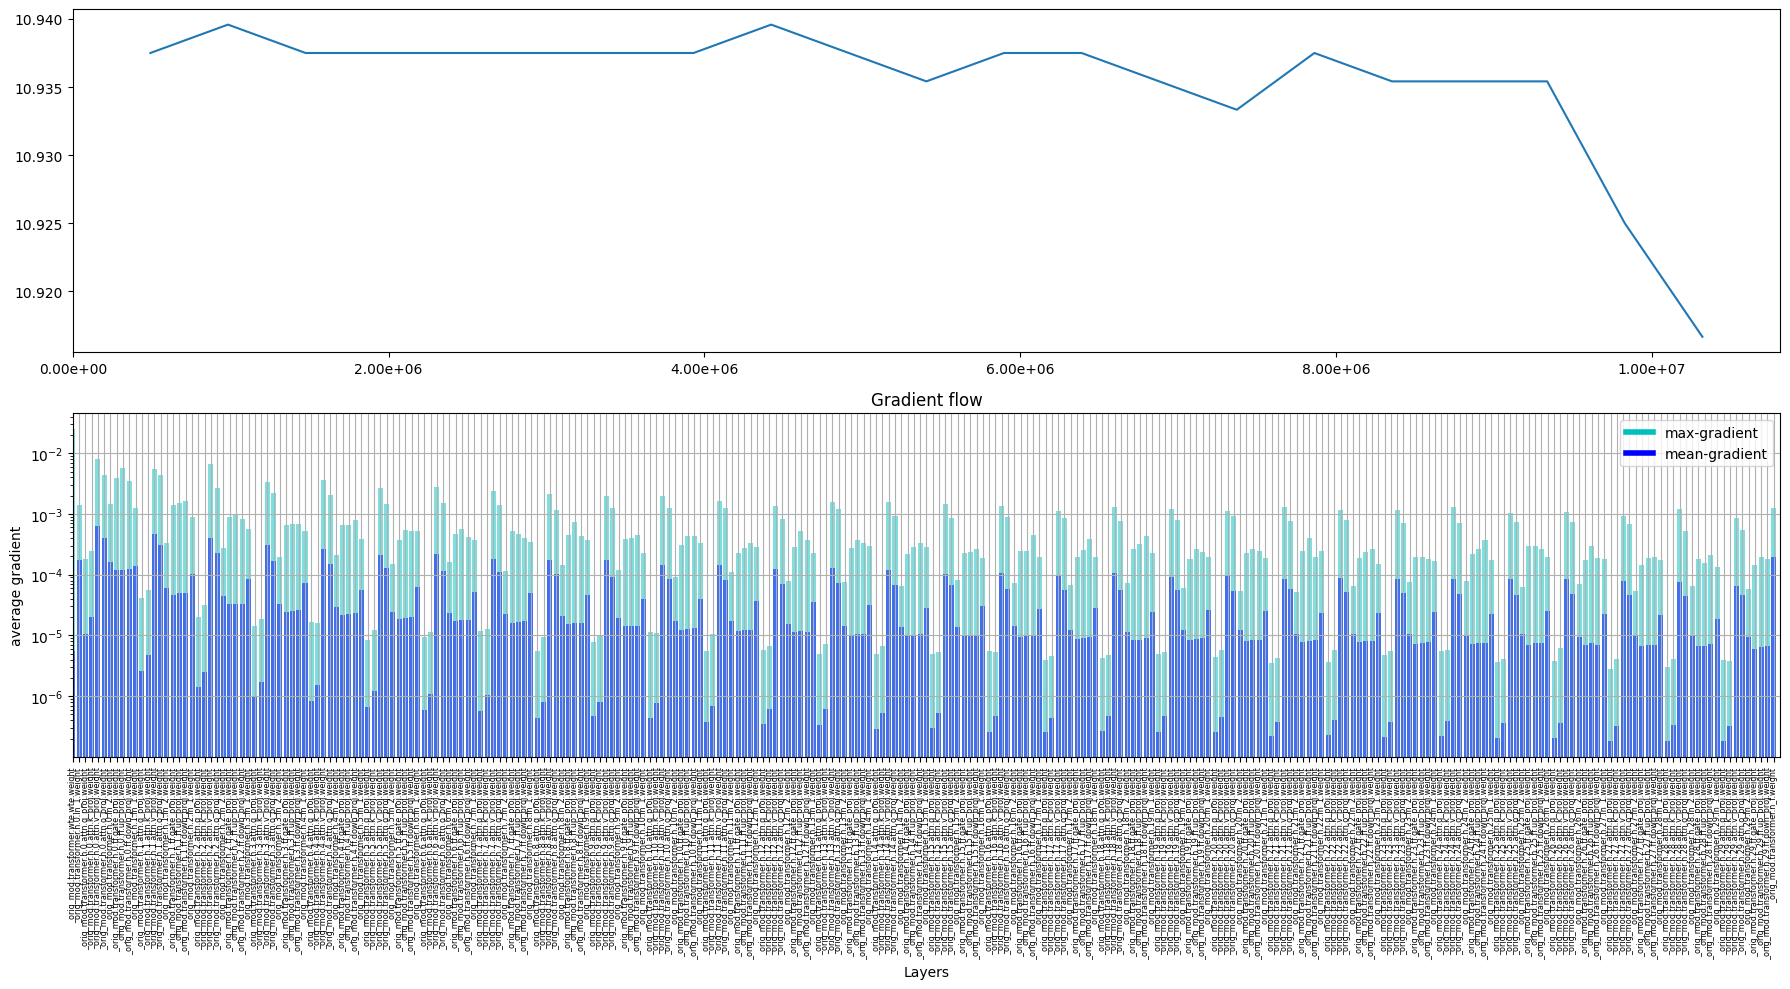

  2%|█▎                                                                             | 34/2000 [05:01<4:50:31,  8.87s/it]


KeyboardInterrupt: 

In [ ]:
train_model(model)